In [1]:
import numpy as np
import QuTFyP
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from math import pi

# Setting up the simulation: 
2-level system (qubit) @ 6.0 (GHz)

8-level system with no anharmonicity @ 9.5 (GHz) - the resonator

coupling via $\hat{x}_1\hat{x}_2$, coupling strength 0.1 (GHz)

resonator decays with rate 0.1 ($\mathrm{ns}^{-1}$)

In [40]:
qed = QuTFyP.TransmonQED()
rwa = False
qed.d = [2, 8] # one degree of freedom with two levels: a qubit
qed.rdtype_np = np.float32
qed.cdtype_np = np.complex64
qed.rdtype = tf.float32
qed.cdtype = tf.complex64
qed.ntraj = 1000
qed.anharmonicities = [0.0, 0.0] #  anharmonicity is irrelevant for two-level systems
qed.frequencies = [2*pi*6.0, 2*pi*9.5] # in GHz. Transmon is 6.0, resonator is 9.5.
qed.couplings = [[0.0, 2*pi*0.1], [2*pi*0.1, 0.0]] # coupling constants between different degrees of freedom
qed.initialize_operators()
qed.controls = {}
qed.minibatch = 100 # number of time steps with a single noise sample and without resampling
qed.simulation_time = 1000.0
qed.dt = 0.01
qed.decoherences = {'resonator_decay':{'measurement_type':'homodyne',
                          'coupling_type':'a',
                          'rate':0.1,
                          'subsystem_id':1,
                          'record':True,
                          'unmix':True,
                          'unmix_reference':2*pi*9.5 if rwa else 0.,
                          'sample_rate':20.,
                          'noise_spectral_density': np.ones((1,), dtype=qed.rdtype_np)}}



In [41]:
qed.expectations = { 'qubit_x': {'unmix':True,
                          'unmix_reference':2*pi*6. if rwa else 0., 
                          'sample_rate':20.,
            'observable_vec': lambda x,t: tf.real(qed.am_td_expect(x,t,ax=0)),
            'observable_mat': lambda x,t: qed.observable(tf.real(qed.am_d2(x, ax=0)), mode='mat') },
                          'qubit_y': {'unmix':True,
                          'unmix_reference':2*pi*6. if rwa else 0., 
                          'sample_rate':20.,
            'observable_vec': lambda x,t: tf.imag(qed.am_td_expect(x,t,ax=0)),
            'observable_mat': lambda x,t: qed.observable(tf.imag(qed.am_d2(x, ax=0)), mode='mat') },
                          'qubit_z': {'unmix':True,
                          'unmix_reference':2*pi*0., 
                          'sample_rate':20.,
            'observable_vec': lambda x,t: qed.observable(tf.real(tf.conj(x)*x*qed.multipliers_sqr_real[0])),
            'observable_mat': lambda x,t: qed.observable(tf.real(qed.multipliers_sqr_real[0]*x), mode='mat') },
                   'res_x': {'unmix':True,
                          'unmix_reference':2*pi*6. if rwa else 0., 
                          'sample_rate':20.,
            'observable_vec': lambda x,t: tf.real(qed.am_td_expect(x,t,ax=1)),
            'observable_mat': lambda x,t: qed.observable(tf.real(qed.am_d2(x, ax=1)), mode='mat') },
                          'res_y': {'unmix':True,
                          'unmix_reference':2*pi*6. if rwa else 0., 
                          'sample_rate':20.,
            'observable_vec': lambda x,t: tf.imag(qed.am_td_expect(x,t,ax=1)),
            'observable_mat': lambda x,t: qed.observable(tf.imag(qed.am_d2(x, ax=1)), mode='mat') },
                          'res_n': {'unmix':True,
                          'unmix_reference':2*pi*0., 
                          'sample_rate':20.,
            'observable_vec': lambda x,t: qed.observable(tf.real(tf.conj(x)*x*qed.multipliers_sqr_real[1])),
            'observable_mat': lambda x,t: qed.observable(tf.real(qed.multipliers_sqr_real[1]*x), mode='mat') }}

In [46]:
qed.ntraj = 1
qed.initialize_operators()
gi = [[1,0,i] for i in range(qed.ntraj)]  # A list of coordinates to update.
gv = [1.0]*qed.ntraj  # A list of values corresponding to the respective
        # coordinate in indices.
qed.set_initial_pure_state(gi, gv)
expectations_mat = qed.run('mat_pure') # master equation solution


qed.ntraj = 1000
qed.initialize_operators()
gi = [[1,0,i] for i in range(qed.ntraj)]  # A list of coordinates to update.
gv = [1.0]*qed.ntraj  # A list of values corresponding to the respective
        # coordinate in indices.
qed.set_initial_pure_state(gi, gv)
expectations_vec_homodyne, measurements_vec_homodyne = qed.run('vec') # run homodyne solution

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [18:22<00:00, 84.21it/s]


homodyne
homodyne
homodyne
homodyne


100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [14:52<00:00, 112.06it/s]


# Plotting Purcell decay
Theory:
    
$\gamma_\mathrm{Pur} = \kappa g^2/\Delta^2=0.1\times\left(0.1/3.5\right)^2=1.8 \times 10^{-5}$

$\langle n_q \rangle = e^{-\gamma_\mathrm{Pur} t}$

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


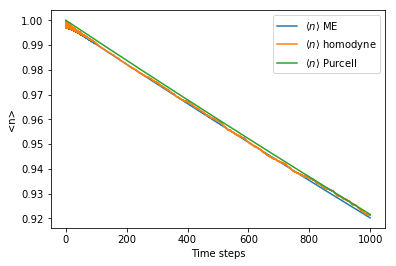

In [49]:
#plt.plot(expectations_mat['qubit_x'][:, 0])
#plt.plot(expectations_mat['qubit_y'][:, 0])
tax = np.arange(0, qed.simulation_time, 1/qed.expectations['qubit_z']['sample_rate'])
gamma_pur = qed.couplings[0][1]**2*qed.decoherences['resonator_decay']['rate']/(qed.frequencies[1]-qed.frequencies[0])**2
gamma = qed.decoherences['resonator_decay']['rate']
plt.plot(tax, expectations_mat['qubit_z'][:, 0], label='$\\langle n \\rangle$ ME')
plt.plot(tax, np.mean(expectations_vec_homodyne['qubit_z'], axis=1), label='$\\langle n \\rangle$ homodyne')
plt.plot(tax, np.exp(-tax*gamma_pur), label='$\\langle n \\rangle$ Purcell')
#plt.plot(tax, np.exp(-tax*gamma), label='$\\langle n \\rangle$ direct')
plt.legend()
plt.xlabel('Time steps')
plt.ylabel('<n>')
plt.savefig('Purcell.png')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


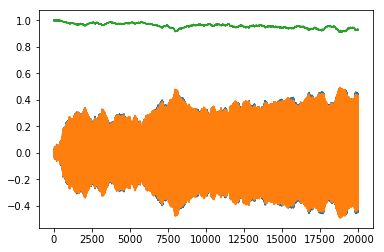

In [48]:
plt.plot(expectations_vec_homodyne['qubit_x'][:, 0])
plt.plot(expectations_vec_homodyne['qubit_y'][:, 0])
plt.plot(expectations_vec_homodyne['qubit_z'][:, 0])
plt.show()